In [3]:
import torch
import librosa
import torchaudio
import os
import pandas as pd

import math, random

import matplotlib.pyplot as plt
from torchaudio import transforms
from IPython.display import Audio


In [4]:
# Enable GPU access and defining plotting functions

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print("Number of available GPUs:", device_count)
    for i in range(device_count):
        print("GPU", i, ":", torch.cuda.get_device_name(i))
else:
    print("GPU is not available")

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots()  # Create a single Axes object
    ax.plot(time_axis, waveform[0], linewidth=1)  # Plot the waveform
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

GPU is not available


In [5]:
input_dir = "./datasets/SoundSynth/Data/genres_original"
output_dir = "./output"

def split_audio(audio_file, output_dir, num_segments=5, original_name=""):
    try:
        waveform, sample_rate = torchaudio.load(audio_file)
    except RuntimeError:
        print(f"Failed to load: {audio_file}")
        return  # Exit if loading fails to prevent further processing

    # Segment length calculation
    total_duration = waveform.size(1) / sample_rate
    segment_duration = total_duration / num_segments
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Split the audio into segments and save each segment as a separate file
    for i in range(num_segments):
        start = int(i * segment_duration * sample_rate)
        end = int((i + 1) * segment_duration * sample_rate)

        # Ensure end does not exceed the waveform length
        if end > waveform.size(1):
            end = waveform.size(1)
        
        segment_waveform = waveform[:, start:end]

        # Construct unique name for the segment based on original file name
        segment_name = f"{original_name}_segment_{i + 1}.wav"
        output_file = os.path.join(output_dir, segment_name)
        
        torchaudio.save(output_file, segment_waveform, sample_rate)

# Function to split audio files and save segments
def split_audio_files(input_dir, output_dir, num_segments=5):
    # Iterate through each class folder
    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        # Ensure it's a directory
        if os.path.isdir(class_path):
            # Create corresponding output class folder
            output_class_path = os.path.join(output_dir, class_folder)
            os.makedirs(output_class_path, exist_ok=True)
            
            # Iterate through audio files in the class folder
            for audio_file in os.listdir(class_path):
                audio_file_path = os.path.join(class_path, audio_file)
                # Ensure it's a file
                if os.path.isfile(audio_file_path):
                    # Split the audio file
                    split_audio(audio_file_path, output_class_path, num_segments, audio_file)

# Call the function to split audio files
split_audio_files(input_dir, output_dir, num_segments=5)

Failed to load: ./datasets/SoundSynth/Data/genres_original\jazz\jazz.00054.wav


In [6]:

GTZAN = output_dir
gtzan_directory_list = os.listdir(GTZAN)

file_genre = []
file_path = []

for folder in gtzan_directory_list:
    files_path = os.path.join(GTZAN, folder)
    for audio in os.listdir(files_path):
        file_genre.append(folder)
        file_path.append(files_path + "/" + audio)

In [7]:
genre_df = pd.DataFrame(file_genre, columns=["Genre"])
path_df = pd.DataFrame(file_path, columns=["Path"])
gtzan_df = pd.concat([genre_df, path_df], axis=1)
gtzan_df.sample(n=10, random_state = 42)

,Genre,Path
84,blues,./output\blues/blues.00016.wav_segment_5.wav
3036,metal,./output\metal/metal.00008.wav_segment_2.wav
1497,country,./output\country/country.00099.wav_segment_3.wav
653,classical,./output\classical/classical.00030.wav_segment...
877,classical,./output\classical/classical.00075.wav_segment...
2897,jazz,./output\jazz/jazz.00080.wav_segment_3.wav
157,blues,./output\blues/blues.00031.wav_segment_3.wav
3610,pop,./output\pop/pop.00023.wav_segment_1.wav
751,classical,./output\classical/classical.00050.wav_segment...
3225,metal,./output\metal/metal.00046.wav_segment_1.wav


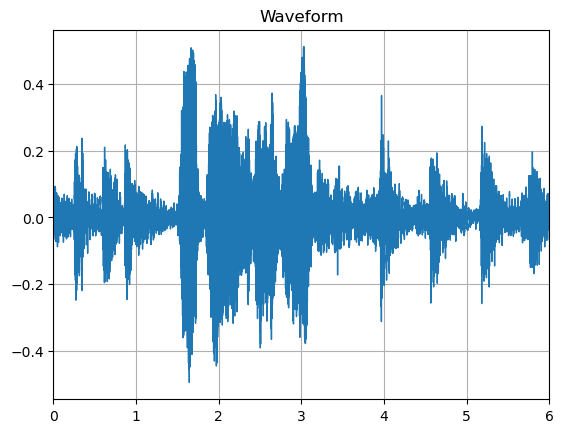

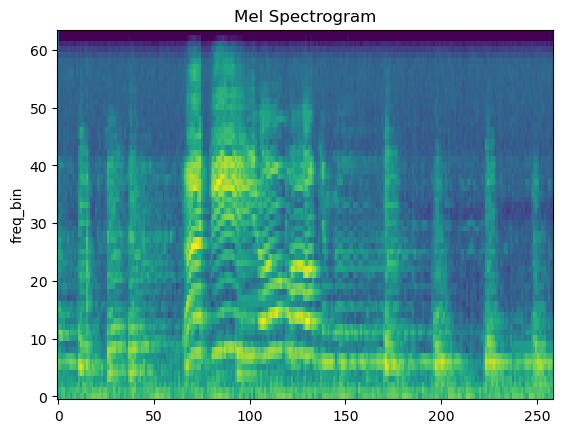

In [9]:
class AudioUtil():
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud
        if (sig.shape[0] == new_channel):
            return aud
        if (new_channel == 1):
            resig = sig[:1, :]
        else:
            resig = torch.cat([sig, sig])
            
        return ((resig, sr))
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud
        if (sr == newsr):
            return aud
        
        num_channels = sig.shape[0]
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
        return ((resig, newsr))
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            sig = torch.cat((pad_begin, sig, pad_end), 1)
            
        return (sig, sr)
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80
        
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        return (spec)
    
aud = AudioUtil.open(gtzan_df.Path[75])
rechannel = AudioUtil.rechannel(aud, 1)
plot_waveform(rechannel[0], rechannel[1])
plot_spectrogram(AudioUtil.spectro_gram(rechannel)[0], title= "Mel Spectrogram")

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(gtzan_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [10]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.class_names = sorted(dataframe['Genre'].unique())
        self.class_to_index = {class_name: i for i, class_name in enumerate(self.class_names)}
        self.file_list = [(row['Path'], self.class_to_index[row['Genre']]) for index, row in dataframe.iterrows()]
        self.transform = transform
        
        self.sr = 44100
        self.duration = 5500
        self.channel = 1
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        audio_file, class_id = self.file_list[idx]
        
        aud = AudioUtil.open(audio_file)
        resample = AudioUtil.resample(aud, self.sr)
        rechannel = AudioUtil.rechannel(resample, self.channel)
        equal_dur = AudioUtil.pad_trunc(rechannel, self.duration)
        melspectrogram = AudioUtil.spectro_gram(equal_dur)

        return melspectrogram, class_id
        
        
def create_data_loader(audio_folder, max_batch_size=16, shuffle=True):
    # Create AudioDataset
    audio_dataset = AudioDataset(audio_folder)
    
    # Create DataLoader
    data_loader = torch.utils.data.DataLoader(audio_dataset, batch_size=max_batch_size, shuffle=shuffle)
    
    return data_loader

In [11]:
class_names = gtzan_df['Genre'].unique()
print(class_names)

train_loader = create_data_loader(train_df)
val_loader = create_data_loader(val_df)
test_loader = create_data_loader(test_df)

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


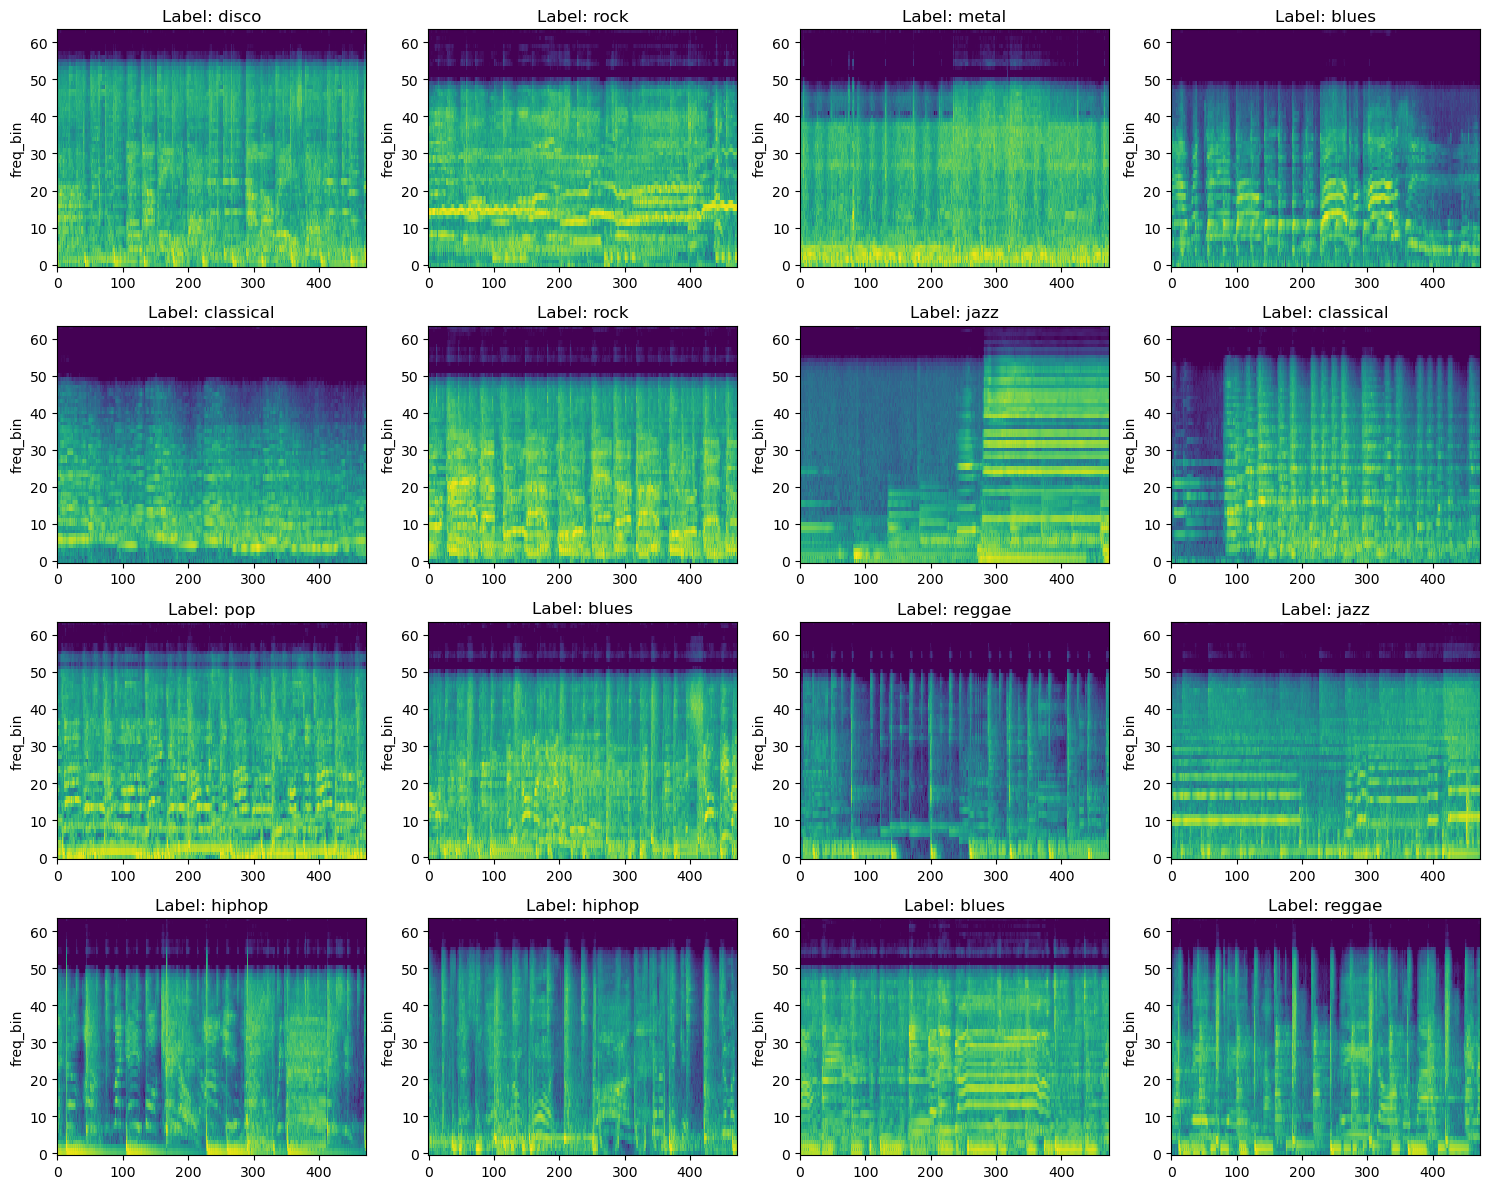

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_from_loader(data_loader, num_images=16):
    # Randomly select num_images indices
    indices = np.random.choice(len(data_loader.dataset), num_images, replace=False)
    
    # Extract spectrograms and labels using the selected indices
    spectrograms = []
    labels = []
    for idx in indices:
        spectrogram, label = data_loader.dataset[idx]
        # Assuming the first channel is the spectrogram data
        spectrogram_data = spectrogram[0]
        spectrograms.append(spectrogram_data)
        labels.append(label)

    # Create a grid of images
    rows = int(np.ceil(num_images / 4))
    fig, axes = plt.subplots(rows, 4, figsize=(15, 3 * rows))

    for i, (specgram, label) in enumerate(zip(spectrograms, labels)):
        ax = axes[i // 4, i % 4] if rows > 1 else axes[i % 4]
        plot_spectrogram(specgram, title=f"Label: {class_names[label]}", ax=ax)

    plt.tight_layout()
    plt.show()


show_images_from_loader(train_loader)

In [13]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 8 * 59, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout_fc = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

model = SpectrogramCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
from tqdm import tqdm

num_epochs = 20
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Wrap train_loader with tqdm to display progress
    train_iterator = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for batch_idx, (inputs, labels) in enumerate(train_iterator):
        inputs = inputs.float().to(device)  # Convert to float and move to device
        labels = labels.to(device)  # Move labels tensor to the device
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        train_iterator.set_postfix(loss=running_loss / ((batch_idx + 1) * train_loader.batch_size))  # Update progress bar
        
    # Calculate average training loss per epoch
    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.float().to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation accuracy
    val_accuracy = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}")

    # Save the best model based on validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'DM_gtzan_best.pth')

print(f"Best validation accuracy: {best_accuracy:.2%}")

Epoch [1/20], Training Loss: 2.2086, Validation Accuracy: 38.00%


Epoch [2/20], Training Loss: 1.7592, Validation Accuracy: 51.50%


Epoch [3/20], Training Loss: 1.6182, Validation Accuracy: 53.75%


Epoch [4/20], Training Loss: 1.4807, Validation Accuracy: 58.25%


Epoch [5/20], Training Loss: 1.3954, Validation Accuracy: 56.75%


Epoch [6/20], Training Loss: 1.3134, Validation Accuracy: 62.00%


Epoch [7/20], Training Loss: 1.2337, Validation Accuracy: 63.25%


Epoch [8/20], Training Loss: 1.2100, Validation Accuracy: 64.00%


Epoch [9/20], Training Loss: 1.1743, Validation Accuracy: 63.25%


Epoch [10/20], Training Loss: 1.1006, Validation Accuracy: 67.75%


Epoch [11/20], Training Loss: 1.0693, Validation Accuracy: 57.50%


Epoch [12/20], Training Loss: 1.0316, Validation Accuracy: 61.75%


Epoch [13/20], Training Loss: 1.0042, Validation Accuracy: 58.25%


Epoch [14/20], Training Loss: 0.9639, Validation Accuracy: 68.00%


Epoch [15/20], Training Loss: 0.9271, Validation Accuracy: 65.25%


Epoch [16/20], Training Loss: 0.8737, Validation Accuracy: 69.75%


Epoch [17/20], Training Loss: 0.8595, Validation Accuracy: 64.75%


Epoch [18/20], Training Loss: 0.8436, Validation Accuracy: 66.25%


Epoch [19/20], Training Loss: 0.8075, Validation Accuracy: 67.75%


Epoch [20/20], Training Loss: 0.7945, Validation Accuracy: 64.50%
Best validation accuracy: 69.75%


C:\Users\johnsobd\AppData\Local\Temp\ipykernel_11636\852108084.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('DM_gtzan_best.pth'))


Test Accuracy: 68.77%


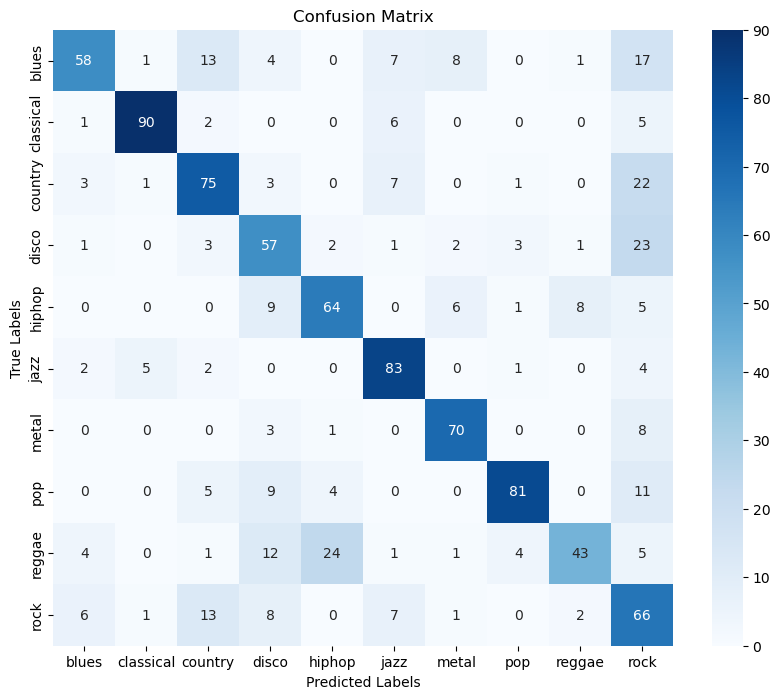

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model
model.load_state_dict(torch.load('DM_gtzan_best.pth'))
model = model.to(device)
model.eval()

# Test
correct_test = 0
total_test = 0
predicted_labels = []
true_labels = []
wrong_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.float().to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        # Identify wrong predictions
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                wrong_predictions.append({
                    'Audio': inputs[i],  # Assuming inputs contain audio data
                    'True Label': labels[i].item(), 
                    'Predicted Label': predicted[i].item()
                })
# Calculate test accuracy
test_accuracy = correct_test / total_test

print(f"Test Accuracy: {test_accuracy:.2%}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()